size(sampling rate)에 따라 AUC값이 어떻게 변화할지

In [43]:
import time
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from category_encoders import TargetEncoder
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# 원본 데이터 로드
train_origin = pd.read_csv('/Users/jaesolshin/내 드라이브/2024-2/Google ML Bootcamp2024/data/playground1/train.csv')


In [44]:
# 데이터 샘플링
#train_origin = train_origin.sample(frac=0.01, random_state = 42)

# 예측에 필요 없는 'id'와 'Annual_Premium' 변수를 드롭
train_origin = train_origin.drop(columns=['id'])

# 범주형 변수 인코딩
def encoding(train):
    gender_mapping = {'Male': 0, 'Female': 1}
    vehicle_age_mapping = {'< 1 Year': 0, '1-2 Year': 1, '> 2 Years': 2}
    vehicle_damage_mapping = {'No': 0, 'Yes': 1}

    train['Gender'] = train['Gender'].map(gender_mapping)
    train['Vehicle_Age'] = train['Vehicle_Age'].map(vehicle_age_mapping)
    train['Vehicle_Damage'] = train['Vehicle_Damage'].map(vehicle_damage_mapping)

    return train

train_origin = encoding(train_origin)

# 범주형 변수 타겟 인코딩
cat_columns = ['Region_Code', 'Policy_Sales_Channel', 'Vintage']
train_origin.loc[:,cat_columns] = train_origin.loc[:,cat_columns].astype('category')

target_encoder = TargetEncoder()
train_origin[cat_columns] = target_encoder.fit_transform(train_origin[cat_columns],train_origin['Response'])

#수치형 변수: Age, Region_Code, Annual Premium, Policy_Sales_Channel, Vintage -> normalize
scaler = MinMaxScaler()
num_columns = ['Age', 'Annual_Premium']
train_origin[num_columns] = scaler.fit_transform(train_origin[num_columns])

# XGBoost에서 발생하는 문제 해결
train_origin.columns = train_origin.columns.str.replace('[', '').str.replace(']', '').str.replace('<', '')

In [45]:
# 샘플 비율 로그 스케일로 생성
fractions = np.logspace(-3, 0, num=9)

# 결과 저장용 데이터프레임
results = pd.DataFrame(columns=["Model", "Sample Size", "Fold", "ROC-AUC", "Training Time"])

# StratifiedKFold 설정
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for frac in fractions:
    train = train_origin.sample(frac=frac, random_state=42)

    X = train.drop(['Response'], axis=1)
    y = train['Response']

    sample_size = len(X)
    
    model_name = "LightGBM"
    model = LGBMClassifier()
    
    fold_idx = 1
    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # 두 개 이상의 클래스가 있는지 확인
        if len(np.unique(y_train)) > 1 and len(np.unique(y_test)) > 1:
            start_time = time.time()
            model.fit(X_train, y_train)
            training_time = time.time() - start_time
            
            y_pred = model.predict_proba(X_test)[:, 1]
            roc_auc = roc_auc_score(y_test, y_pred)
            
            # 새로운 행 데이터
            new_row = {
                "Model": model_name,
                "Sample Size": sample_size,
                "Fold": fold_idx,
                "ROC-AUC": roc_auc,
                "Training Time": training_time
            }

            # 새로운 행을 데이터프레임으로 변환
            new_row_df = pd.DataFrame([new_row])

            # pd.concat을 사용하여 새로운 행 추가
            results = pd.concat([results, new_row_df], ignore_index=True)

            print(f"Model: {model_name}, Sample Size: {sample_size}, Fold: {fold_idx}, ROC-AUC: {roc_auc:.4f}, Training Time: {training_time:.2f} seconds")
        
        fold_idx += 1

# 결과 확인
print(results)

[LightGBM] [Info] Number of positive: 1088, number of negative: 8116
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049887 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 676
[LightGBM] [Info] Number of data points in the train set: 9204, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.118209 -> initscore=-2.009496
[LightGBM] [Info] Start training from score -2.009496


/var/folders/fx/7qldcfl92nb_g9hqp_lrssxm0000gn/T/ipykernel_71482/1559980451.py:48: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, new_row_df], ignore_index=True)


Model: LightGBM, Sample Size: 11505, Fold: 1, ROC-AUC: 0.8663, Training Time: 2.48 seconds
[LightGBM] [Info] Number of positive: 1088, number of negative: 8116
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000157 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 668
[LightGBM] [Info] Number of data points in the train set: 9204, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.118209 -> initscore=-2.009496
[LightGBM] [Info] Start training from score -2.009496
Model: LightGBM, Sample Size: 11505, Fold: 2, ROC-AUC: 0.8538, Training Time: 0.15 seconds
[LightGBM] [Info] Number of positive: 1088, number of negative: 8116
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000148 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you c

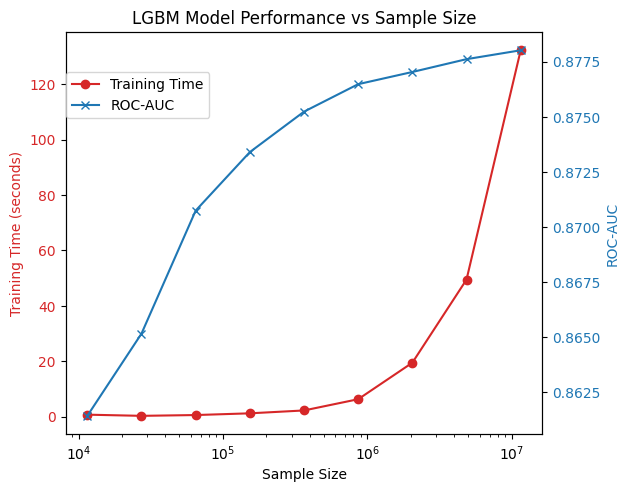

In [50]:
# 결과 시각화
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Sample Size')
ax1.set_ylabel('Training Time (seconds)', color=color)
mean_training_time = results.groupby("Sample Size")["Training Time"].mean()
ax1.plot(mean_training_time.index,
         mean_training_time,
         label='Training Time', marker='o', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xscale('log')  # x축을 로그 스케일로 설정

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('ROC-AUC', color=color)
mean_roc_auc = results.groupby("Sample Size")["ROC-AUC"].mean()
ax2.plot(mean_roc_auc.index,
         mean_roc_auc,
         label='ROC-AUC', marker='x', color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_xscale('log')  # x축을 로그 스케일로 설정

fig.tight_layout()
plt.title('LGBM Model Performance vs Sample Size')
fig.legend(loc='upper left', bbox_to_anchor=(0.1,0.9))
plt.show()
